In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
import torch
import torch.nn as nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

In [3]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [5]:
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
reviews = pd.read_csv('data/reviews.csv.zip', sep='\t')
reviews.drop_duplicates(subset=['review'], inplace=True)
reviews.head(10)

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative
5,Очень глубокие проймы,negative
6,Я недовольна заказом.Я вот одного не понимаю п...,negative
7,"заказала размер s на от 64,об 94,начнем с того...",negative
8,Заказ я сделала в июле. С тех пор посылка отсл...,negative
9,Ужасное качество товара!,negative


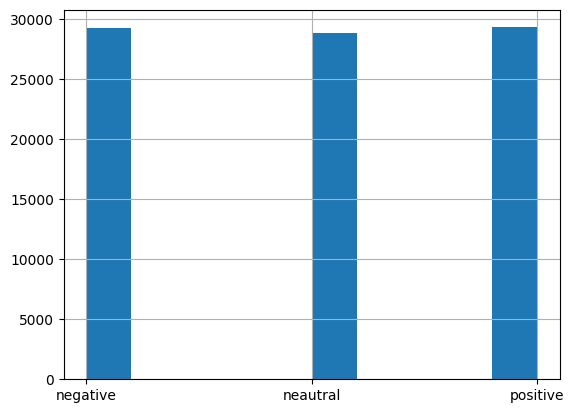

In [7]:
reviews.sentiment.hist()
plt.show()

In [8]:
sentiment_map = {
    'negative': 0,
    'neautral': 1,
    'positive': 2
}

In [9]:
reviews.sentiment = reviews.sentiment.apply(lambda x: sentiment_map[x])
reviews.head(10)

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,0
1,"Товар отдали другому человеку, я не получила п...",0
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0
3,"товар не пришел, продавец продлил защиту без м...",0
4,"Кофточка голая синтетика, носить не возможно.",0
5,Очень глубокие проймы,0
6,Я недовольна заказом.Я вот одного не понимаю п...,0
7,"заказала размер s на от 64,об 94,начнем с того...",0
8,Заказ я сделала в июле. С тех пор посылка отсл...,0
9,Ужасное качество товара!,0


In [10]:
reviews_sample = reviews.sample(frac=0.15, replace=True, random_state=42)
reviews_sample.shape

(13098, 2)

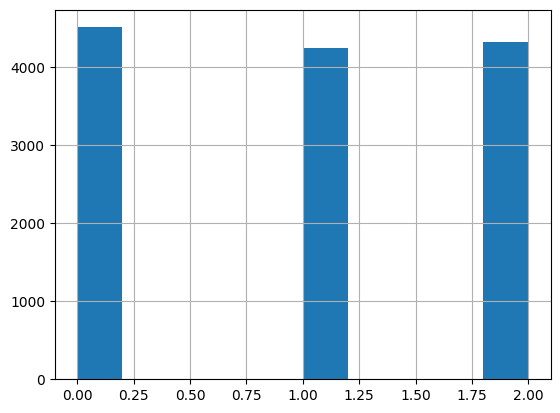

In [11]:
reviews_sample.sentiment.hist()
plt.show()

In [12]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [13]:
pretrained_model_name_or_path = 'DeepPavlov/rubert-base-cased'

In [14]:
num_labels = reviews.sentiment.nunique()
num_labels

3

In [15]:
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path, 
                                                      num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model = model.to(device)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [17]:
embedding_parameters = [param for name, param in model.named_parameters() 
                        if 'classifier' not in name]

In [18]:
for param in embedding_parameters:
    param.requires_grad = False

In [19]:
X = reviews_sample.review
y = reviews_sample.sentiment

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
tokenizer.pad_token_id = 0
print(tokenizer.pad_token)

[PAD]


In [22]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, X, y, tokenizer=None, num_labels=3):
        self.X = tokenizer(X.tolist(), 
                           truncation=True, 
                           padding=True,
                           return_tensors="pt",
                           max_length=512).to(device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64).to(device)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X.input_ids[idx], self.X.attention_mask[idx], self.y[idx]

In [23]:
train_dataset = SentimentAnalysisDataset(X_train, y_train, tokenizer)
test_dataset = SentimentAnalysisDataset(X_test, y_test, tokenizer)

free_memory()

In [24]:
batch_size = 32
num_epochs = 15

In [25]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [26]:
optimizer = AdamW(model.classifier.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [37]:
def evaluate_model(model, data_loader):
    ground_truth = []
    predictions = []

    model.eval()
    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, indices = torch.max(outputs.logits, 1)
        predictions.extend(indices.tolist())
        ground_truth.extend(labels.tolist())
        del input_ids
        del attention_mask
        del labels
        del outputs
        del indices
        free_memory()
    accuracy = accuracy_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions, average='macro')
    del predictions
    del ground_truth
    free_memory()
    return accuracy, f1

In [28]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, 
                step_size=1, gamma=0.5):
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss_history = []
    train_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (input_ids, attention_mask, y) in enumerate(train_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            #logits = torch.mean(outputs.logits, dim=1)
            optimizer.zero_grad()
            loss = criterion(outputs.logits, y)
            loss.backward()
            clip_grad_norm_(model.classifier.parameters(), 1.0)
            optimizer.step()
            
            _, indices = torch.max(outputs.logits, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss
            
            del outputs
            del indices
            del input_ids
            del attention_mask
            del y
            free_memory()
          
        scheduler.step()
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        
        free_memory()

        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))
        
    return loss_history, train_history

In [29]:
loss_history, train_history = train_model(model, 
                                          train_loader, 
                                          criterion, 
                                          optimizer, num_epochs)

Average loss: 0.987085, Train accuracy: 0.524814
Average loss: 0.893772, Train accuracy: 0.582458
Average loss: 0.870194, Train accuracy: 0.598015
Average loss: 0.857395, Train accuracy: 0.612044
Average loss: 0.852505, Train accuracy: 0.609658
Average loss: 0.848166, Train accuracy: 0.610708
Average loss: 0.844660, Train accuracy: 0.618343
Average loss: 0.844936, Train accuracy: 0.622161
Average loss: 0.847967, Train accuracy: 0.624547
Average loss: 0.842989, Train accuracy: 0.617293
Average loss: 0.845643, Train accuracy: 0.623783
Average loss: 0.847046, Train accuracy: 0.620920
Average loss: 0.840913, Train accuracy: 0.622065
Average loss: 0.846919, Train accuracy: 0.621684
Average loss: 0.843450, Train accuracy: 0.618152


In [30]:
free_memory()

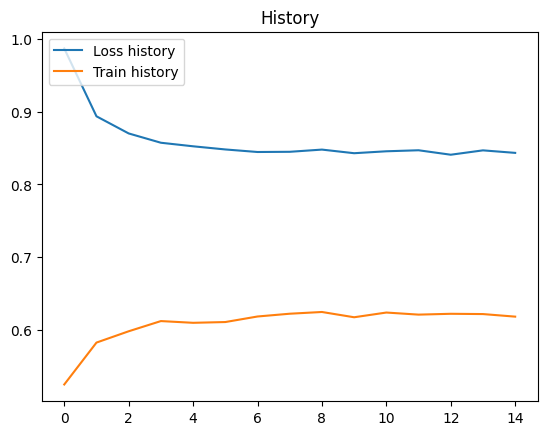

In [31]:
plt.title("History")
plt.plot(loss_history, label="Loss history")
plt.plot(train_history, label="Train history")
plt.legend(loc="upper left")
plt.show()

In [32]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [38]:
accuracy, f1 = evaluate_model(model, test_loader)
print(f"Test accuracy is {accuracy}")
print(f"Test f1 score is {f1}")

Test accuracy is 0.6515267175572519
Test f1 score is 0.6463834249748095


In [39]:
torch.save(model, 'st_rubert-sentiment-classifier.pth')